[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kdlamb/SP2-VAE/blob/main/SP2_2DLatentSpace.ipynb)

## SP2 2D Latent Space Analysis
This notebook uses the pyroVED library to analyze signals from the Single Particle Soot Photometer. Here we use a 2D latent space for the scattering and incandescent channels from the NOAA SP2.

## Download the L-II signal data
You can download the NOAA SP2 data directly from the [Zenodo repository](https://zenodo.org/records/15800436) by uncommenting and running the following code (can be slow). Alternatively, you can first download the data directly to your computer and then upload the files to Colab.

In [1]:
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_train.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_train.npy"
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_val.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_val.npy"
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_test.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_test.npy"

## Install packages and load in libraries

In [2]:
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git

  Preparing metadata (setup.py) ... done


In [3]:
import os
import math
import numpy as np
import seaborn as sns
import pandas as pd
import time
import random

import torch

from torch.nn import Conv1d, ConvTranspose1d
from torch.nn import Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
from tqdm import tqdm

In [4]:
import pyroved as pv
import torch
import matplotlib.pyplot as plt

In [5]:
# for reproducibility
np.random.seed(0)
torch.manual_seed(0)

## Preprocess SP2 Data Sets

In [53]:
X_train = np.load("Lab_X_train.npy")
Y_train = np.load("Lab_Y_train.npy")

X_val = np.load("Lab_X_val.npy")
Y_val = np.load("Lab_Y_val.npy")

X_test = np.load("Lab_X_test.npy")
Y_test = np.load("Lab_Y_test.npy")

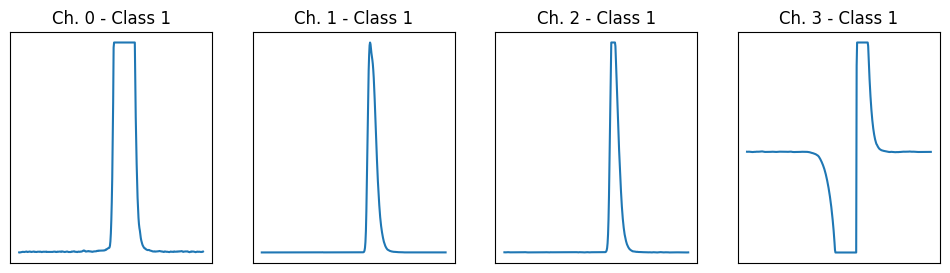

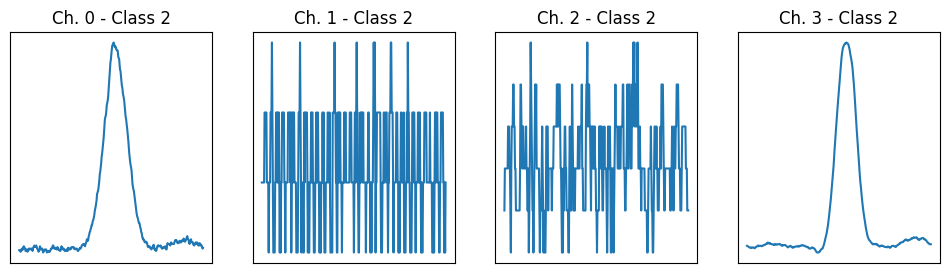

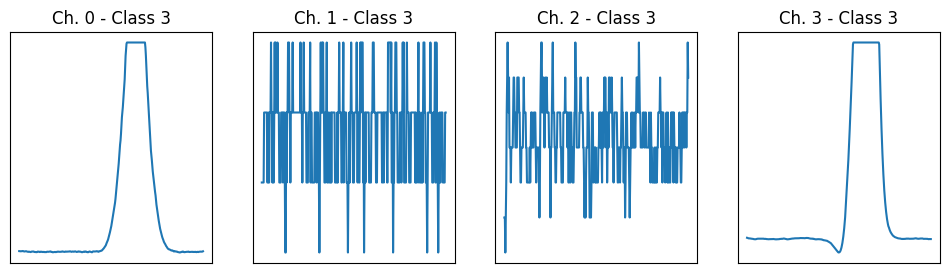

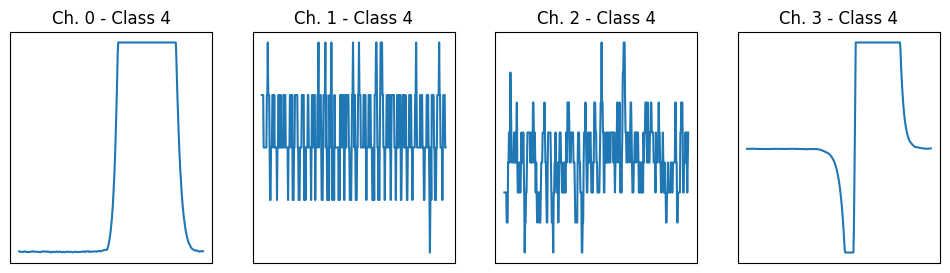

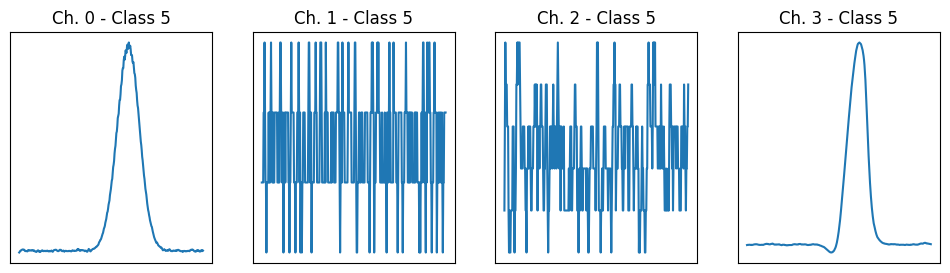

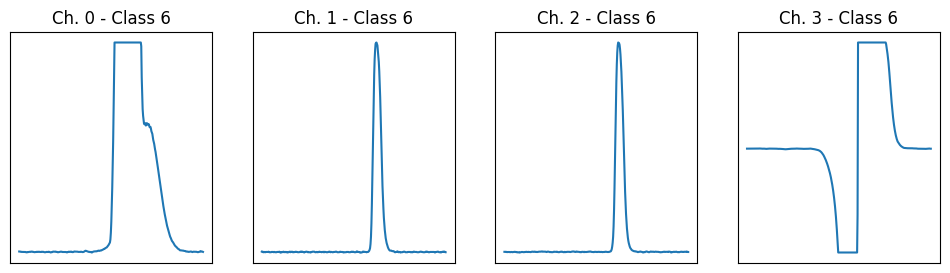

In [7]:
import random
import matplotlib.pyplot as plt

for class_label in range(1, 7):
    class_indices = [i for i, label in enumerate(Y_train) if label == class_label]

    random_index = random.choice(class_indices)

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
    axes[0].plot(X_train[random_index, :, 0])
    axes[0].set_title(f"Ch. 0 - Class {class_label}")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].plot(X_train[random_index, :, 1])
    axes[1].set_title(f"Ch. 1 - Class {class_label}")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[2].plot(X_train[random_index, :, 2])
    axes[2].set_title(f"Ch. 2 - Class {class_label}")
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[3].plot(X_train[random_index, :, 3])
    axes[3].set_title(f"Ch. 3 - Class {class_label}")
    axes[3].set_xticks([])
    axes[3].set_yticks([])

    plt.show()

[ 0.27351301 -0.0099272   0.06618134 -2.51282528]
[ 0.24095415  0.012409    0.09513567 -2.51871128]
[ 0.25802354 -0.0198544  -0.00827267 -2.5069083 ]
[ 0.15055762  0.02399073  0.03391794 -2.6923482 ]
[ 0.27227385  0.01075447  0.01406353 -2.52050805]


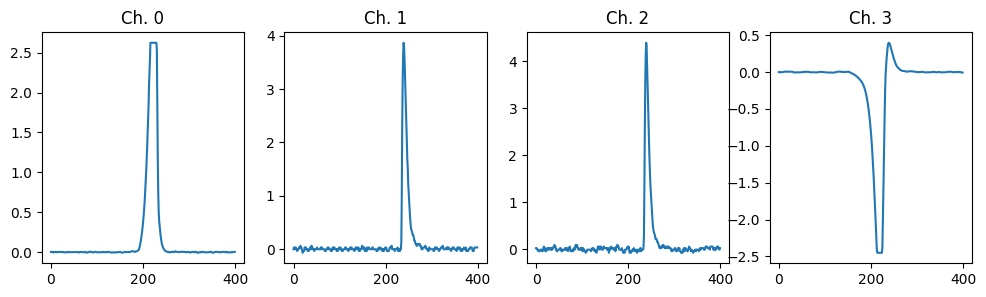

In [8]:
n = random.randint(1, 140081)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(X_train[n,:,0])
axes[0].set_title("Ch. 0")
axes[1].plot(X_train[n,:,1])
axes[1].set_title("Ch. 1")
axes[2].plot(X_train[n,:,2])
axes[2].set_title("Ch. 2")
axes[3].plot(X_train[n,:,3])
axes[3].set_title("Ch. 3")

random_indices = [random.randint(0, 140081) for _ in range(5)]

for idx in random_indices:
    print(X_train[idx, 199, :])

In [54]:
# APPLY INCANDESCENT THRESHOLD
mask = np.any(X_train[:, :, 1] > 0.2, axis=1)
X_train = X_train[mask]
Y_train = Y_train[mask]

In [55]:
import numpy as np

unique_classes_orig, class_counts_orig = np.unique(Y_train, return_counts=True)

mask = np.any(X_train[:, :, 1] > 0.2, axis=1)
X_train_filtered = X_train[mask]
Y_train_filtered = Y_train[mask]

unique_classes_after, class_counts_after = np.unique(Y_train_filtered, return_counts=True)

print("Different aerosol classes detectable incandesence:")
for cls in unique_classes_orig:
    count_orig = class_counts_orig[unique_classes_orig == cls][0]
    count_after = class_counts_after[unique_classes_after == cls][0] if cls in unique_classes_after else 0
    percentage_change = (count_after / count_orig) * 100 if count_orig > 0 else 0
    print(f"Class {cls}: Before = {count_orig}, After = {count_after}, Percentage = {percentage_change:.2f}%")

Different aerosol classes detectable incandesence:
Class 0.0: Before = 19660, After = 19660, Percentage = 100.00%
Class 1.0: Before = 16223, After = 16223, Percentage = 100.00%
Class 2.0: Before = 1706, After = 1706, Percentage = 100.00%
Class 3.0: Before = 4786, After = 4786, Percentage = 100.00%
Class 4.0: Before = 5402, After = 5402, Percentage = 100.00%
Class 5.0: Before = 18377, After = 18377, Percentage = 100.00%
Class 6.0: Before = 19678, After = 19678, Percentage = 100.00%


In [56]:
max1 = np.max(X_train[:, :, 1], axis=1)
max2 = np.max(X_train[:, :, 2], axis=1)

# Calculate the color channel ratio for all 400 points
color_channel_ratio = max1 / max2

color_channel_ratio

array([0.90088466, 0.92368178, 0.82622433, ..., 0.65570257, 0.66796738,
       0.62054155])

In [57]:
channel_min_X_train = np.zeros((len(X_train), 4))
channel_max_X_train = np.zeros((len(X_train), 4))

for p_idx in range(len(X_train)):
  for c_idx in range(4):
    channel_min_X_train[p_idx][c_idx] = np.min(X_train[p_idx, :, c_idx])

  for c_idx in range(4):
    channel_max_X_train[p_idx][c_idx] = np.max(X_train[p_idx, :, c_idx])


for p_idx in range (0,len(X_train)):
  for c_idx in range(0, 4):
    s0 = (X_train[p_idx,:,c_idx] - channel_min_X_train[p_idx][c_idx])/(channel_max_X_train[p_idx][c_idx]- channel_min_X_train[p_idx][c_idx])
    X_train[p_idx,:,c_idx] = s0

X_train.shape


(85832, 400, 4)

## Train VAE models on Ch. 0 and Ch. 1

In [13]:
X_train_C0 = torch.from_numpy(X_train[:,:, 0]).float()
train_loader_0 = pv.utils.init_dataloader(X_train_C0.unsqueeze(1), batch_size=64)

X_train_C1 = torch.from_numpy(X_train[:,:, 1]).float()
train_loader_1 = pv.utils.init_dataloader(X_train_C1.unsqueeze(1), batch_size=64)

In [14]:
# Initialize vanilla VAE
vae0 = pv.models.iVAE(data_dim = (400,), latent_dim = 2, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae0)

In [ ]:
# Train for n epochs:
for e in range(55):
    trainer.step(train_loader_0)
    trainer.print_statistics()
torch.save(vae0.state_dict(), "2DVAE_Ch0.pth")

In [15]:
# Load in the trained model weights
vae0.load_state_dict(torch.load('2DVAE_Ch0.pth'))

<All keys matched successfully>

In [16]:
vae1 = pv.models.iVAE(data_dim = (400,), latent_dim = 2, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer1 = pv.trainers.SVItrainer(vae1)

In [ ]:
# Train for n epochs:
for e in range(55):
    trainer1.step(train_loader_1)
    trainer1.print_statistics()
torch.save(vae1.state_dict(), "2DVAE_Ch1.pth")

In [17]:
# Load in the trained model weights
vae1.load_state_dict(torch.load('2DVAE_Ch1.pth'))

<All keys matched successfully>

## Analyze the latent manifolds for Ch. 0 and Ch. 1

In [18]:
from typing import Optional, Tuple, Union, List
from torchvision.utils import make_grid

from pyroved.utils import (
    generate_grid, generate_latent_grid, get_sampler,
    plot_img_grid, plot_spect_grid, set_deterministic_mode,
    to_onehot, transform_coordinates, gp_model
)

def manifold2d(model, d: int, y: torch.Tensor = None,plot: bool = True,**kwargs: Union[str, int, float]) -> torch.Tensor:

    z, (grid_x, grid_y) = generate_latent_grid(d, **kwargs)
    z = [z]

    loc = model.decode(*z, **kwargs)

    return loc, grid_x,grid_y
def plot_spect_grid(spectra: torch.Tensor, d: int, labels: List[str],
                    xticks: List[float], yticks: List[float], plotname=str):
    """
    Plots a *d*-by-*d* square grid with 1D spectral plots
    """
    fig, axes = plt.subplots(d, d, figsize=(8, 8),
                           subplot_kw={'xticks': [], 'yticks': []},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1))

    spectra = spectra.cpu()
    for ax, y in zip(axes.flat, spectra):
        ax.plot(y.squeeze())

  # Add centered global x and y labels
    fig.text(0.5, 0.04, labels[0], ha='center', va='center', fontsize=18)  # bottom center
    fig.text(0.04, 0.5, labels[1], ha='center', va='center', rotation='vertical', fontsize=18)  # left center

    # Add an invisible global axis for ticks
    ax_big = fig.add_subplot(111, frameon=False)
    ax_big.tick_params(labelcolor='black', top=False, bottom=True,
                       left=True, right=False, labelsize=12)
    ax_big.set_xticks(np.linspace(0.05,0.95,num=d))
    ax_big.set_yticks(np.linspace(0.05,0.95,num=d))
    ax_big.set_xticklabels([f"{x:.2f}" for x in xticks])
    ax_big.set_yticklabels([f"{y:.2f}" for y in yticks])

    # Hide the actual frame
    ax_big.spines[:].set_visible(False)

    plt.savefig(plotname,dpi=300)

In [19]:
manifold0,xvals0,yvals0=manifold2d(vae0,d=10)
manifold1,xvals1,yvals1=manifold2d(vae1,d=10)

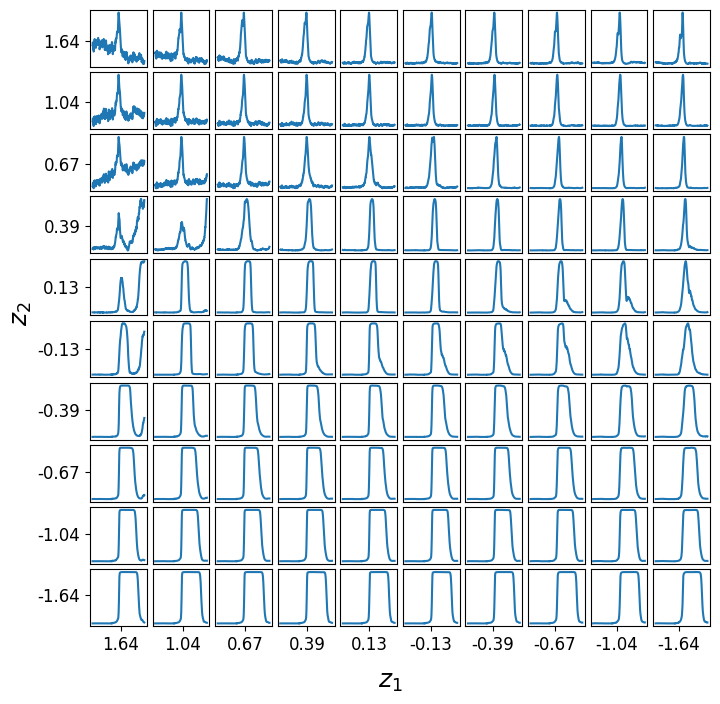

In [20]:
# Manifold Channel 0 (Scattering Channel)
plot_spect_grid(manifold0, d=10,labels=["$z_1$","$z_2$"],xticks=xvals0,yticks=yvals0,plotname="ManifoldCh0.png")

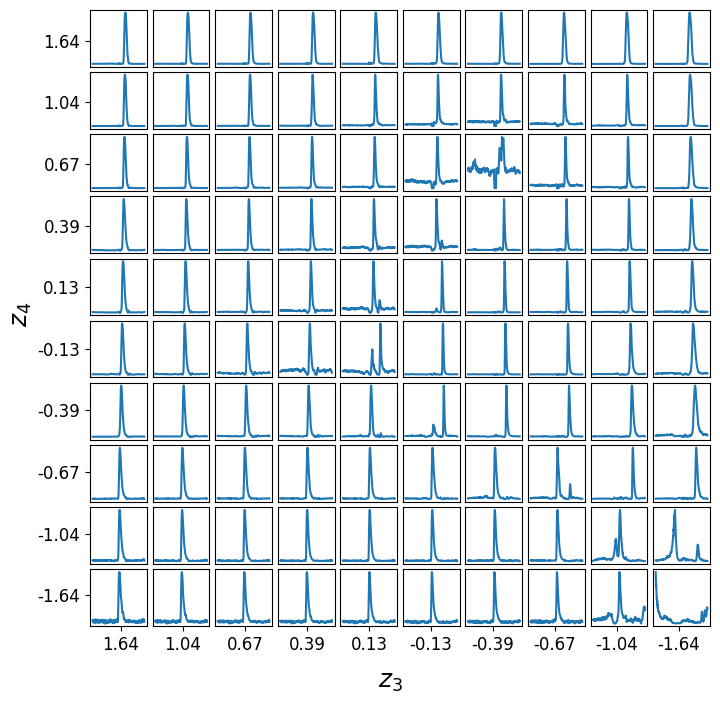

In [21]:
# Manifold Channel 1 (Incandescent Channel)
plot_spect_grid(manifold1, d=10,labels=["$z_3$","$z_4$"],xticks=xvals1,yticks=yvals1,plotname="ManifoldCh1.png")

In [22]:
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.stats import skewnorm
from scipy.optimize import curve_fit


In [28]:
def skewnorm_pdf(x, a, loc, scale):
    return skewnorm.pdf(x, a, loc, scale)
def get_peak_info(signals):
    n = signals.shape[0]
    fwhm = np.zeros(n)
    peakloc = np.zeros(n)
    startloc = np.zeros(n)
    skewness = np.zeros(n)

    for i in range(0,signals.shape[0]):
        x = signals[i,:]
        peaks, peak_properties = find_peaks(x, height=(None, 1))
        maxpeak = np.argmax(peak_properties['peak_heights'])
        peakloc[i]=peaks[maxpeak]

        results_half = peak_widths(x, peaks, rel_height=0.5)
        fwhm[i]=results_half[0][maxpeak]
        startloc[i]=results_half[2][maxpeak]-results_half[0][maxpeak]

        try:
            popt, _ = curve_fit(skewnorm_pdf, np.arange(0,400), x, p0=[5,200,20], maxfev=1000)
            a_fit, loc_fit, scale_fit = popt
        except:
            a_fit = np.nan
        skewness[i] = a_fit

    return peakloc,startloc,fwhm, skewness

In [29]:
peaklocsCh0,startlocsCh0,fwhmCh0,skewnessCh0 = get_peak_info(manifold0)
peaklocsCh1,startlocsCh1,fwhmCh1,skewnessCh1 = get_peak_info(manifold1)

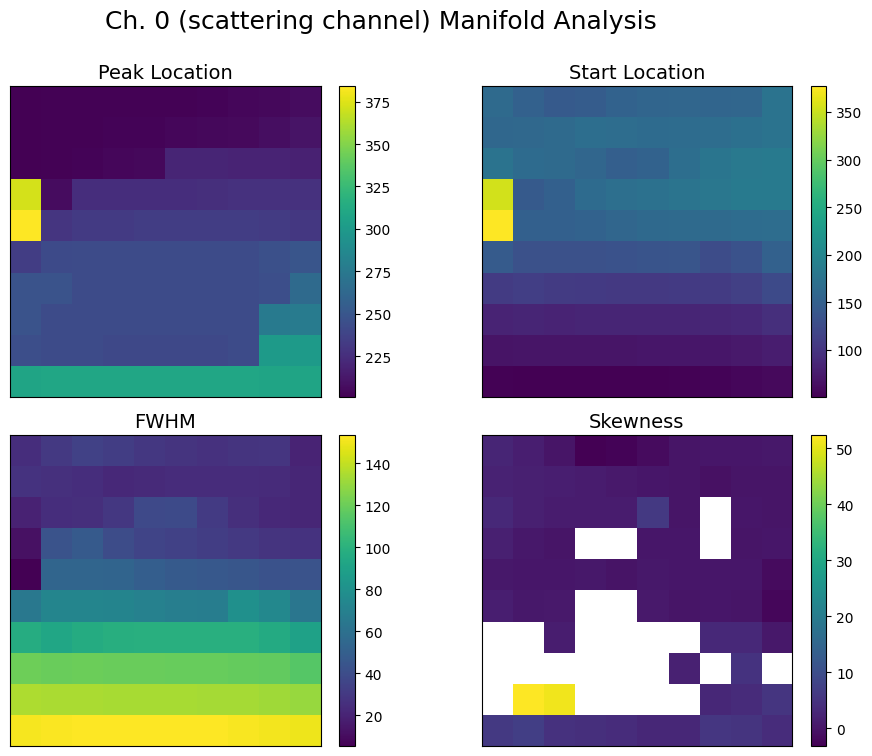

In [33]:
data = [
    ("Peak Location", peaklocsCh0.reshape(10, 10)),
    ("Start Location", startlocsCh0.reshape(10, 10)),
    ("FWHM", fwhmCh0.reshape(10, 10)),
    ("Skewness", skewnessCh0.reshape(10, 10))
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Ch. 0 (scattering channel) Manifold Analysis", fontsize=18, y=0.94)

for ax, (title, img) in zip(axes.flat, data):
    im = ax.imshow(img, cmap='viridis')
    ax.set_title(title, fontsize=14)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

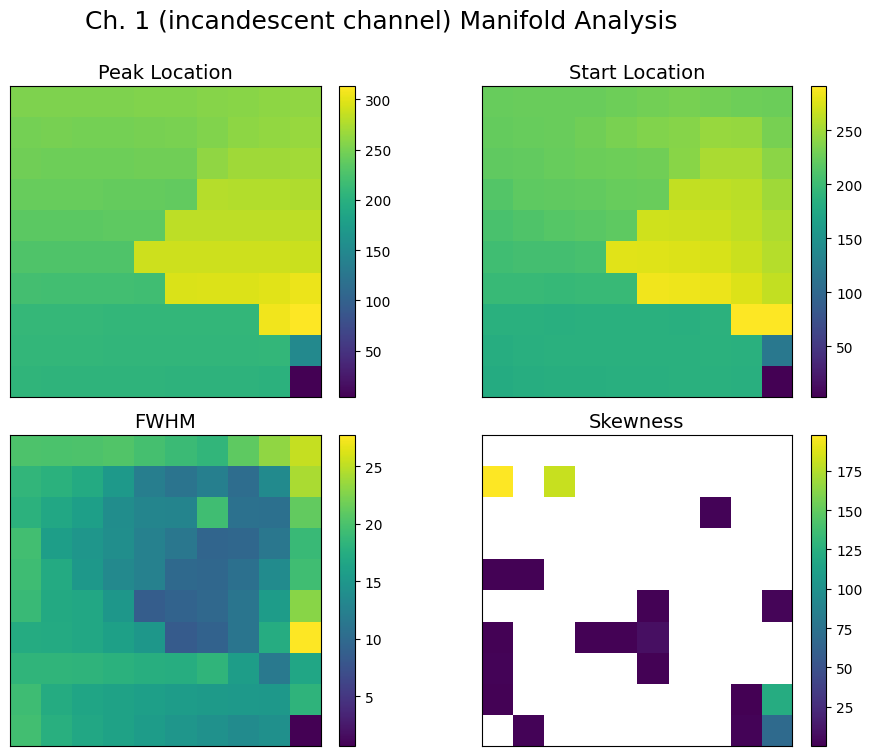

In [34]:
# Reshape to 10x10 grids
data = [
    ("Peak Location", peaklocsCh1.reshape(10, 10)),
    ("Start Location", startlocsCh1.reshape(10, 10)),
    ("FWHM", fwhmCh1.reshape(10, 10)),
    ("Skewness", skewnessCh1.reshape(10, 10))
]

# Create a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Ch. 1 (incandescent channel) Manifold Analysis", fontsize=18, y=0.94)

# Loop through subplots
for ax, (title, img) in zip(axes.flat, data):
    im = ax.imshow(img, cmap='viridis')
    ax.set_title(title, fontsize=14)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

# Optional: remove axis ticks if not meaningful
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

## Compare latent variables in incandescent max. vs. color ratio space

In [58]:
# Encode each sample as latent variables
z_mean_0, z_sd_0 = vae0.encode(X_train_C0)
z_mean_1, z_sd_1 = vae1.encode(X_train_C1)

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.colors import ListedColormap

target_names = ["FS", "FSglyc", "CFA", "ATD", "VA", "Fe2O3", "Fe3O4"]
cmap1 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])

/tmp/ipython-input-2874814071.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(target_names)


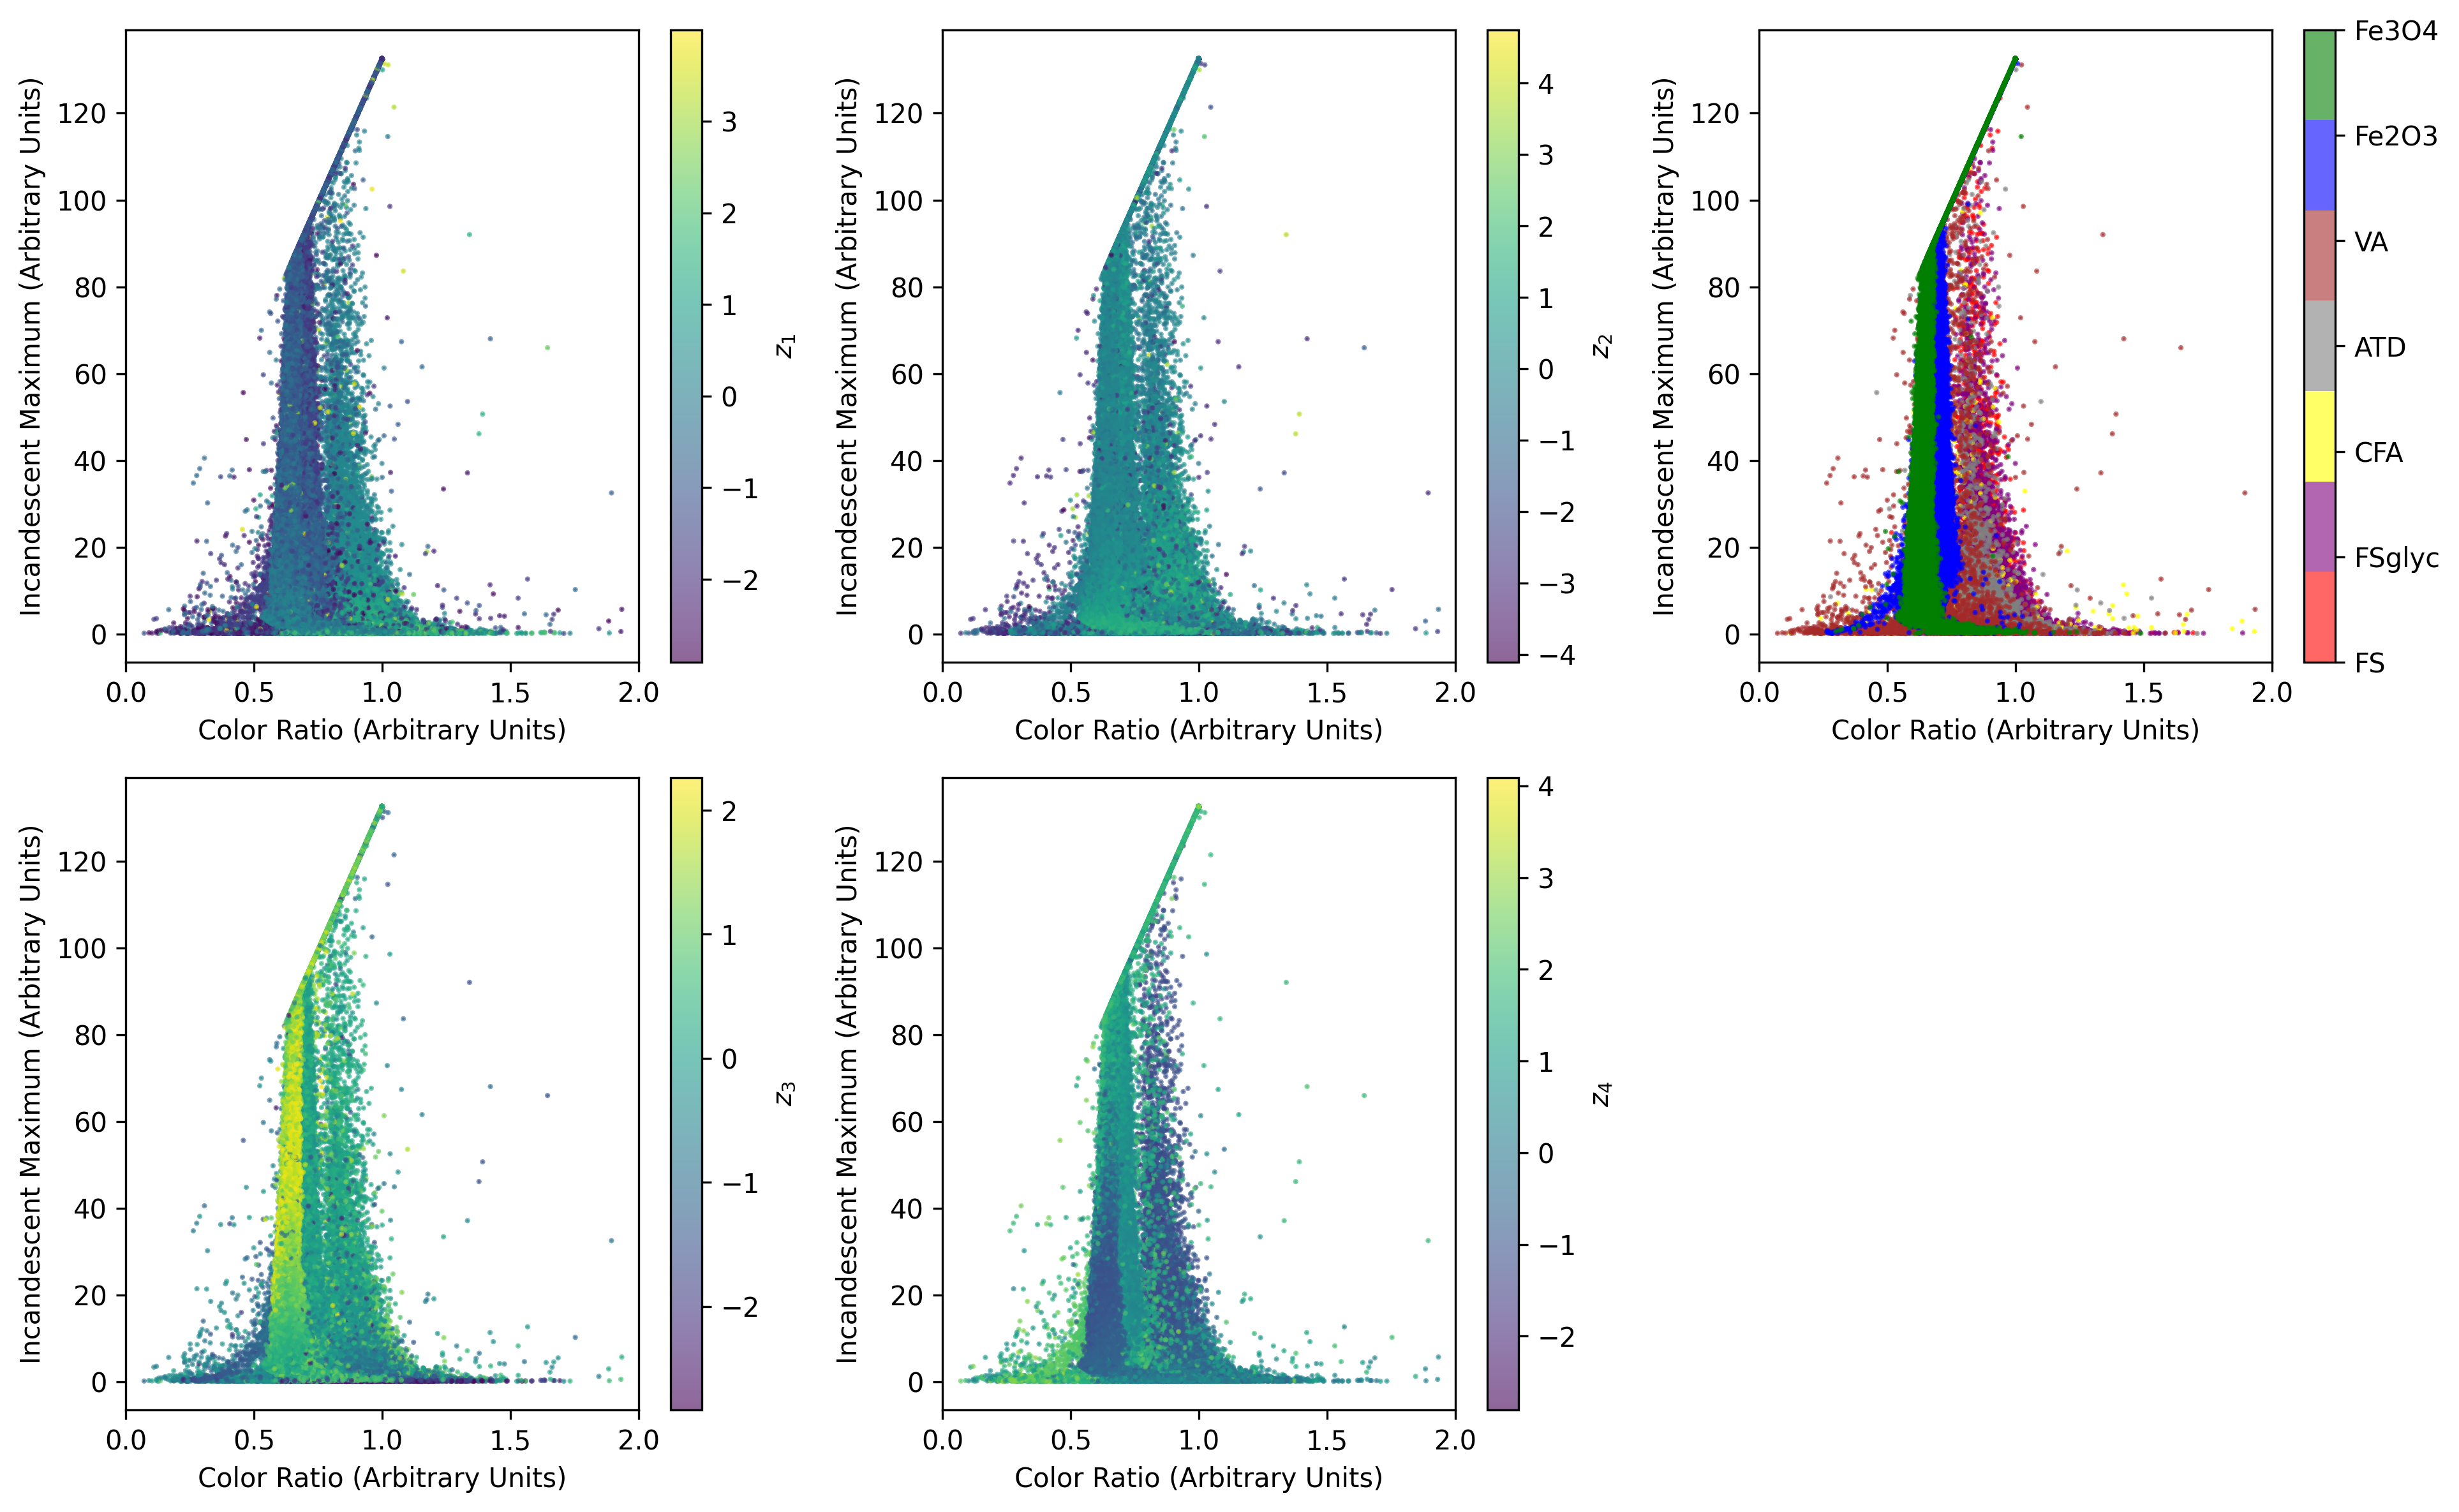

In [61]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,3, figsize=(13, 8), dpi=300)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

z_data = [z_mean_0[:,0], z_mean_0[:,1], z_mean_1[:,0], z_mean_1[:,1]]
z_labels = ['$z_1$', '$z_2$', '$z_3$', '$z_4$']

axes = axes.flatten()

for i in range(2):
    sc = axes[i].scatter(
        color_channel_ratio,
        channel_max_X_train[:,1],
        c=z_data[i],
        s=1,
        cmap='viridis',
        alpha=0.6
    )
    axes[i].set_xlim(0, 2)
    axes[i].set_xlabel("Color Ratio (Arbitrary Units)")
    axes[i].set_ylabel("Incandescent Maximum (Arbitrary Units)")
    cbar = fig.colorbar(sc, ax=axes[i])
    cbar.set_label(z_labels[i])
    # axes[i].set_title(f"Scatter Plot Colored by {z_labels[i]}")


sc = axes[2].scatter(
    color_channel_ratio,
    channel_max_X_train[:,1],
    c=Y_train_filtered,
    s=1,
    cmap=cmap1,
    alpha=0.6
)
axes[2].set_xlim(0, 2)
axes[2].set_xlabel("Color Ratio (Arbitrary Units)")
axes[2].set_ylabel("Incandescent Maximum (Arbitrary Units)")
cbar = fig.colorbar(sc, ax=axes[2])
cbar.set_ticklabels(target_names)

for i in range(2):
    sc = axes[3+i].scatter(
        color_channel_ratio,
        channel_max_X_train[:,1],
        c=z_data[2+i],
        s=1,
        cmap='viridis',
        alpha=0.6
    )
    axes[3+i].set_xlim(0, 2)
    axes[3+i].set_xlabel("Color Ratio (Arbitrary Units)")
    axes[3+i].set_ylabel("Incandescent Maximum (Arbitrary Units)")
    cbar = fig.colorbar(sc, ax=axes[3+i])
    cbar.set_label(z_labels[2+i])
    # axes[i].set_title(f"Scatter Plot Colored by {z_labels[i]}")

axes[5].remove()

plt.tight_layout()
plt.savefig("color_ratio_z1_to_z4.png", dpi=300)
plt.show()
